# US Accident Dataset 2016-2023

## Data Collection (Raw Data)

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#sklearn models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scipy.spatial.distance import mahalanobis

#sklearn preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#sklearn postprocessing
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


#sklearn helpers/analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#Remove deprecated warnings
import warnings
warnings.filterwarnings('ignore')

In [63]:
#Some visualization settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [64]:
df = pd.read_csv('data/US_Accidents_March23.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

There are a total of 45 data features in this dataset not including the index. Reporting this info will help us understand what features may be useful for our analysis. For example, we have a data frame for Start_Time and End_Time object types. From this we can actually expand the features to include the year, month, day, weekday, and hour of the accident.

### Expanding the Data (Time Duration)

In [65]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

timeduration = 'Time_Duration(td)'
df[timeduration]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
#Show these new columns added
df[['Start_Time','End_Time','Year','Month','Day','Hour','Weekday',timeduration]].head(5)

,Start_Time,End_Time,Year,Month,Day,Hour,Weekday,Time_Duration(td)
0,2016-02-08 05:46:00,2016-02-08 11:00:00,2016.0,Feb,8.0,5.0,Mon,314.0
1,2016-02-08 06:07:59,2016-02-08 06:37:59,2016.0,Feb,8.0,6.0,Mon,30.0
2,2016-02-08 06:49:27,2016-02-08 07:19:27,2016.0,Feb,8.0,6.0,Mon,30.0
3,2016-02-08 07:23:34,2016-02-08 07:53:34,2016.0,Feb,8.0,7.0,Mon,30.0
4,2016-02-08 07:39:07,2016-02-08 08:09:07,2016.0,Feb,8.0,7.0,Mon,30.0


Awesome now can move on to cleaning the data up and preparing it for analysis/training. First we will check for negative time durations and clean up any outliers.

In [66]:
x=0
df_tennessee = df[(df['State']=='TN')]
if df_tennessee[timeduration].isnull().values.any():
    x +=1
print(f'There are {x-1} records where Time_Duration is negative')
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident time: {} minutes.'.format(df_tennessee[timeduration].max(),round(df_tennessee[timeduration].max()/60), round(df_tennessee[timeduration].max()/60/24), df_tennessee[timeduration].min()))
print('The median time to clear an accident is {} minutes or {} hours.'.format(df_tennessee[timeduration].median(),round(df_tennessee[timeduration].median()/60)))
print('The average time to clear an accident is {} minutes or {} hours.'.format(round(df_tennessee[timeduration].mean()),round(df_tennessee[timeduration].mean()/60)))


There are 0 records where Time_Duration is negative
Max time to clear an accident: 400785.0 minutes or 6680 hours or 278 days; Min to clear an accident time: 3.0 minutes.
The median time to clear an accident is 62.0 minutes or 1 hours.
The average time to clear an accident is 111 minutes or 2 hours.


In [67]:
#Find outliers and replace with median
irange=3
median = df_tennessee[timeduration].median()
std = df_tennessee[timeduration].std()
outliers = (df_tennessee[timeduration] - median).abs() > std*irange
df_tennessee[outliers] = np.nan
df_tennessee[timeduration].fillna(median, inplace=True)

In [68]:
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident time: {} minutes.'.format(df_tennessee[timeduration].max(),round(df_tennessee[timeduration].max()/60), round(df_tennessee[timeduration].max()/60/24), df_tennessee[timeduration].min()))
print('The median time to clear an accident is {} minutes or {} hours.'.format(df_tennessee[timeduration].median(),round(df_tennessee[timeduration].median()/60)))
print('The average time to clear an accident is {} minutes or {} hours.'.format(round(df_tennessee[timeduration].mean()),round(df_tennessee[timeduration].mean()/60)))

Max time to clear an accident: 4228.0 minutes or 70 hours or 3 days; Min to clear an accident time: 3.0 minutes.
The median time to clear an accident is 62.0 minutes or 1 hours.
The average time to clear an accident is 97 minutes or 2 hours.


### Label Encoding

In [69]:
#df_tennessee = df[(df['State']=='TN')]
#df_tennessee.dropna(inplace=True)
categorical_cols = df_tennessee.select_dtypes(include=['object','bool','category']).columns
label_encoder = LabelEncoder()

for col in categorical_cols:
    df_tennessee[col] = label_encoder.fit_transform(df_tennessee[col])

After label encoding the string value features, we can now take a look at the correlation between the features and the severity of the accident. This will help us determine which features are most important for our analysis.

## Feature Extraction

We begin by looking for the most correlated features in the dataset with respect to accident severity

In [70]:
df_tennessee = df_tennessee.drop(['Civil_Twilight', 'Nautical_Twilight', 'Sunrise_Sunset','Astronomical_Twilight', 'End_Lat', 'End_Lng', 'Start_Time', 'End_Time', 'Description', 'Airport_Code', 'Turning_Loop', 'Country', 'ID'], axis=1)

Severity             1.000000
Source               0.245327
Street               0.136490
County               0.131888
Pressure(in)         0.130765
Zipcode              0.095296
Distance(mi)         0.064514
Humidity(%)          0.055441
Weather_Condition    0.048181
Junction             0.044289
Hour                 0.041951
Timezone             0.035264
Precipitation(in)    0.024471
Wind_Direction       0.024380
Wind_Speed(mph)      0.019695
Day                  0.005237
Traffic_Calming      0.004976
City                 0.001615
Temperature(F)       0.001331
Roundabout          -0.001432
Bump                -0.002265
No_Exit             -0.004170
Start_Lng           -0.008435
Give_Way            -0.014018
Time_Duration(td)   -0.016811
Railway             -0.023919
Visibility(mi)      -0.032367
Stop                -0.033088
Start_Lat           -0.033971
Wind_Chill(F)       -0.040204
Month               -0.043069
Station             -0.050772
Amenity             -0.058556
Weekday   

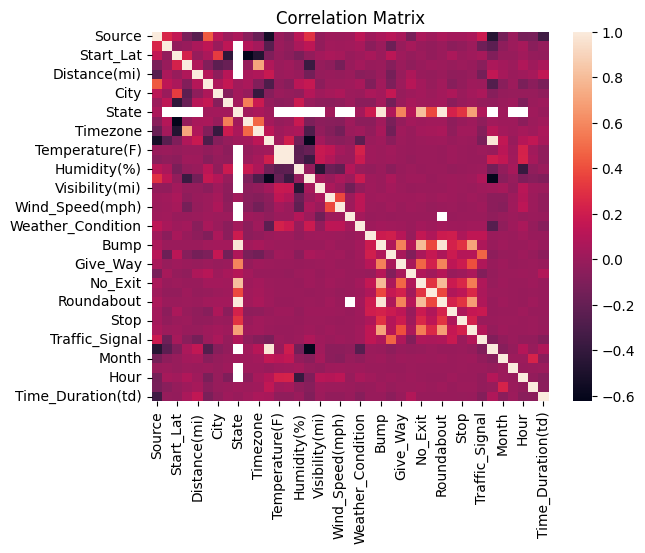

<Figure size 5000x5000 with 0 Axes>

In [71]:
corr_matrix = df_tennessee.corr()
#List the most highly correlated columns
print(corr_matrix['Severity'].sort_values(ascending=False))
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix')
plt.figure(figsize=(50,50))
plt.show()

We removed 'Civil_Twilight', 'Nautical_Twilight', 'Sunrise_Sunset','Astronomical_Twilight' because they had very little positive or negative correlation to the accident severity. 'End_Lat', 'End_Lng' were removed due to overlapping data already covered by 'Start_Lat' and 'Start_Lng'. 'Start_Time' and 'End_Time' were removed because it is covered by the added column of Time_Duration and not as important of a feature as 'Start_Time'. 'Description' was all string object data and is not able to be meaningfully encoded. 'Airport_Code' is non meaningful location data about the nearest airport which we have more granual data in the Latitude and Longitude columns. 'Turning_Loop', 'Country' were the same value for all 8 million entries so they were removed. 

## Other Insights into the Data

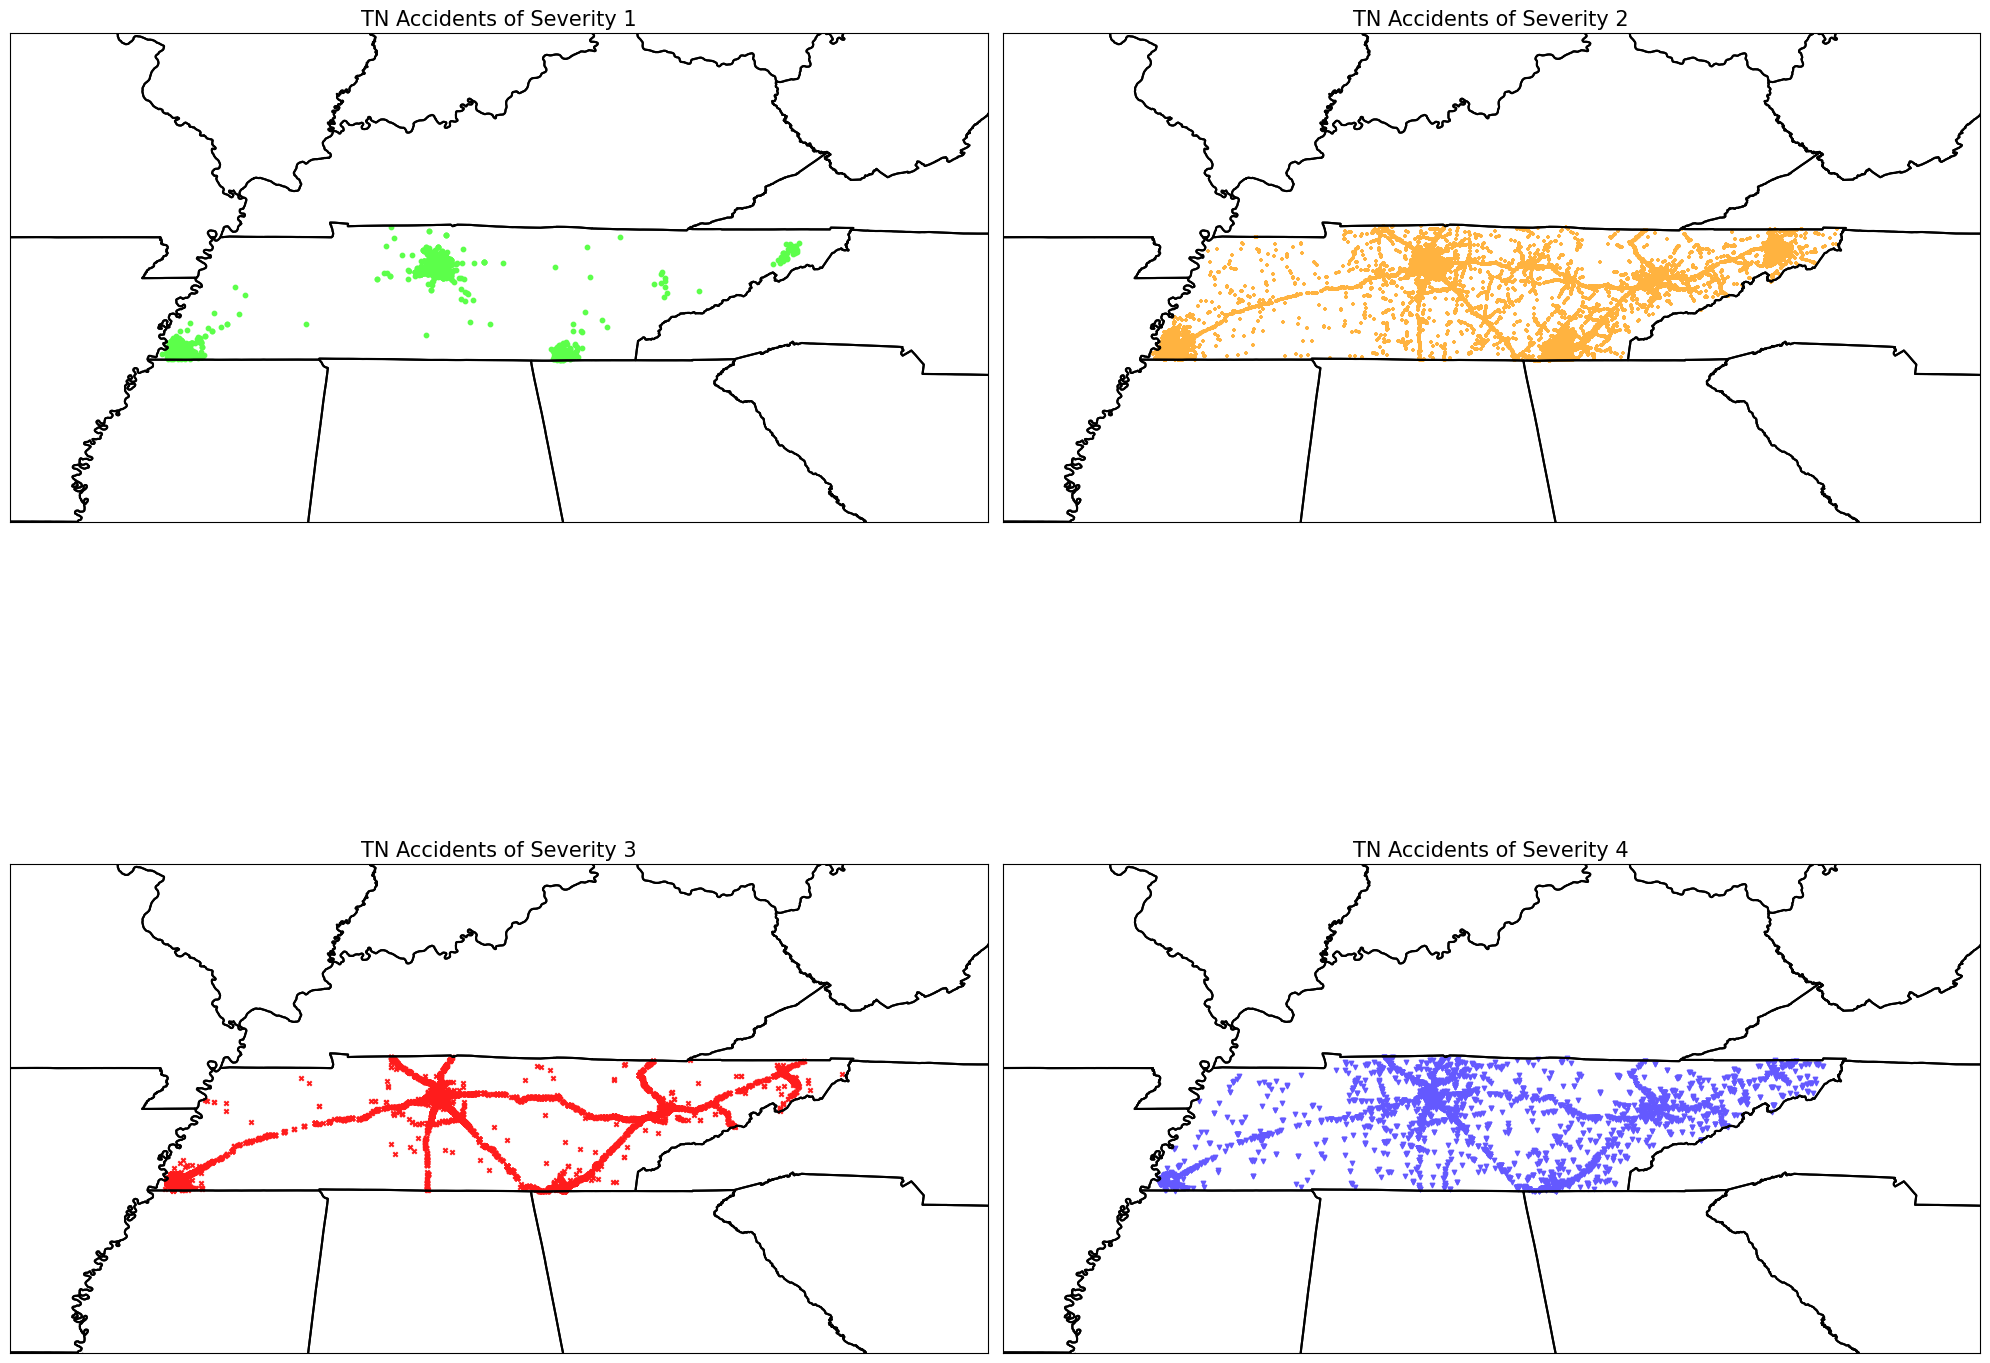

In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
states = gpd.read_file('data/cb_2018_us_state_500k.shx')

#Function to create a map for a given severity
def create_severity_map(severity, color, marker, label, ax):
    geo_df[geo_df['Severity'] == severity].plot(ax=ax, markersize=10, color=color, marker=marker, label=label)

geometry = [Point(xy) for xy in zip(df_tennessee['Start_Lng'], df_tennessee['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df_tennessee, geometry=geometry)

fig, axs = plt.subplots(2, 2, figsize=(20,20))  

#Plot each severity on its own map
create_severity_map(1, '#5cff4a', 'o', 'Severity 1', axs[0, 0])
create_severity_map(2, '#ffb340', '+', 'Severity 2', axs[0, 1])
create_severity_map(3, '#ff1c1c', 'x', 'Severity 3', axs[1, 0])
create_severity_map(4, '#6459ff', 'v', 'Severity 4', axs[1, 1])

for ax in axs.flatten():
    ax.set_xlim([-92, -80])
    ax.set_ylim([33, 39])
    states.boundary.plot(ax=ax, color='black')
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

axs[0, 0].set_title('TN Accidents of Severity 1', size=15)
axs[0, 1].set_title('TN Accidents of Severity 2', size=15)
axs[1, 0].set_title('TN Accidents of Severity 3', size=15)
axs[1, 1].set_title('TN Accidents of Severity 4', size=15)
plt.tight_layout()
plt.show()


Dropping any NaN values

In [73]:
print('Number of NaN or empty values in each column:')
for column in df_tennessee.columns:
    print('{}: {}'.format(column, df_tennessee[column].isnull().sum()))

Number of NaN or empty values in each column:
Source: 0
Severity: 30
Start_Lat: 30
Start_Lng: 30
Distance(mi): 30
Street: 0
City: 0
County: 0
State: 0
Zipcode: 0
Timezone: 0
Weather_Timestamp: 0
Temperature(F): 686
Wind_Chill(F): 34127
Humidity(%): 755
Pressure(in): 420
Visibility(mi): 483
Wind_Direction: 0
Wind_Speed(mph): 8105
Precipitation(in): 35470
Weather_Condition: 0
Amenity: 0
Bump: 0
Crossing: 0
Give_Way: 0
Junction: 0
No_Exit: 0
Railway: 0
Roundabout: 0
Station: 0
Stop: 0
Traffic_Calming: 0
Traffic_Signal: 0
Year: 15520
Month: 0
Day: 15520
Hour: 15520
Weekday: 0
Time_Duration(td): 0


We decided to further remove Precipitation and Wind Chill due to almost a quarter of the data missing. We replaced the rest of the empty data entries with the median for each column

In [74]:
df_tn_extracted = df_tennessee.drop('Wind_Chill(F)', axis=1)
df_tn_extracted = df_tennessee.drop('Precipitation(in)', axis=1)
#Replace NaN or empty values with the median for each column
for column in df_tn_extracted.columns:
    df_tn_extracted[column].fillna(df_tn_extracted[column].median(), inplace=True)
for column in df_tn_extracted.columns:
    print('{}: {}'.format(column, df_tn_extracted[column].isnull().sum()))


Source: 0
Severity: 0
Start_Lat: 0
Start_Lng: 0
Distance(mi): 0
Street: 0
City: 0
County: 0
State: 0
Zipcode: 0
Timezone: 0
Weather_Timestamp: 0
Temperature(F): 0
Wind_Chill(F): 0
Humidity(%): 0
Pressure(in): 0
Visibility(mi): 0
Wind_Direction: 0
Wind_Speed(mph): 0
Weather_Condition: 0
Amenity: 0
Bump: 0
Crossing: 0
Give_Way: 0
Junction: 0
No_Exit: 0
Railway: 0
Roundabout: 0
Station: 0
Stop: 0
Traffic_Calming: 0
Traffic_Signal: 0
Year: 0
Month: 0
Day: 0
Hour: 0
Weekday: 0
Time_Duration(td): 0


## Feature Reduction (PCA and FLD)

In [75]:
#Split the data into training, testing, and validation sets
X = df_tn_extracted.drop('Severity', axis=1)
y = df_tn_extracted['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=21)

In [76]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

### PCA

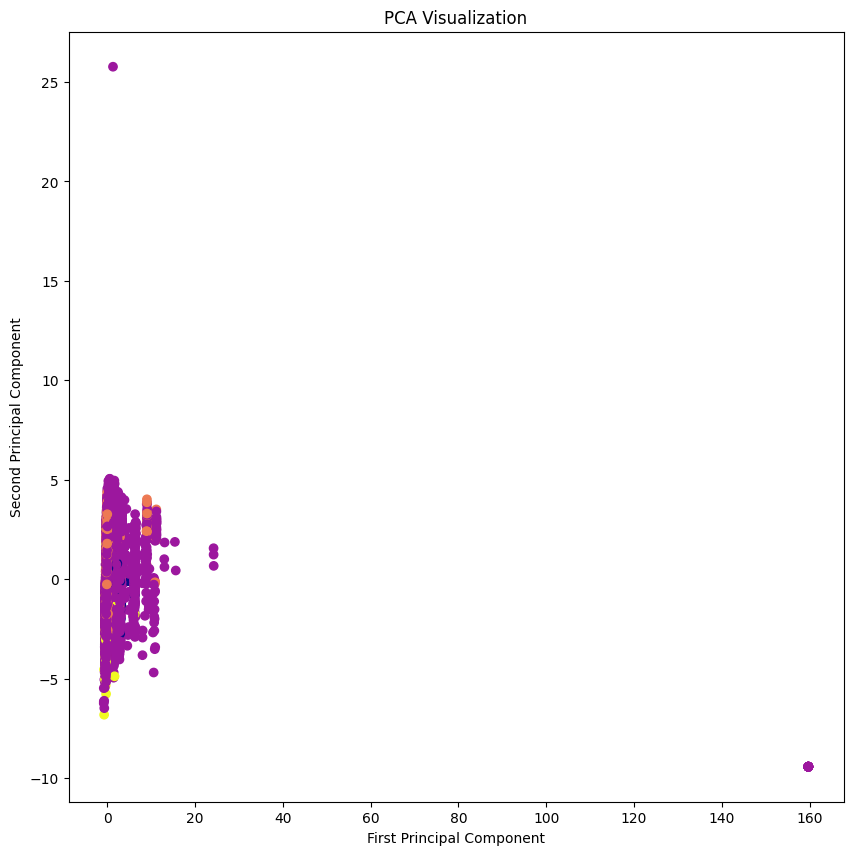

In [77]:
pca = PCA(n_components=30)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)
plt.figure(figsize=(10,10))
plt.scatter(pca_X_train[:,0], pca_X_train[:,1], c=y_train, cmap='plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization')
plt.show()


In [78]:
pca = PCA(n_components=30)
pca.fit(X_test)
pca_X_test = pca.transform(X_test)

### FLD

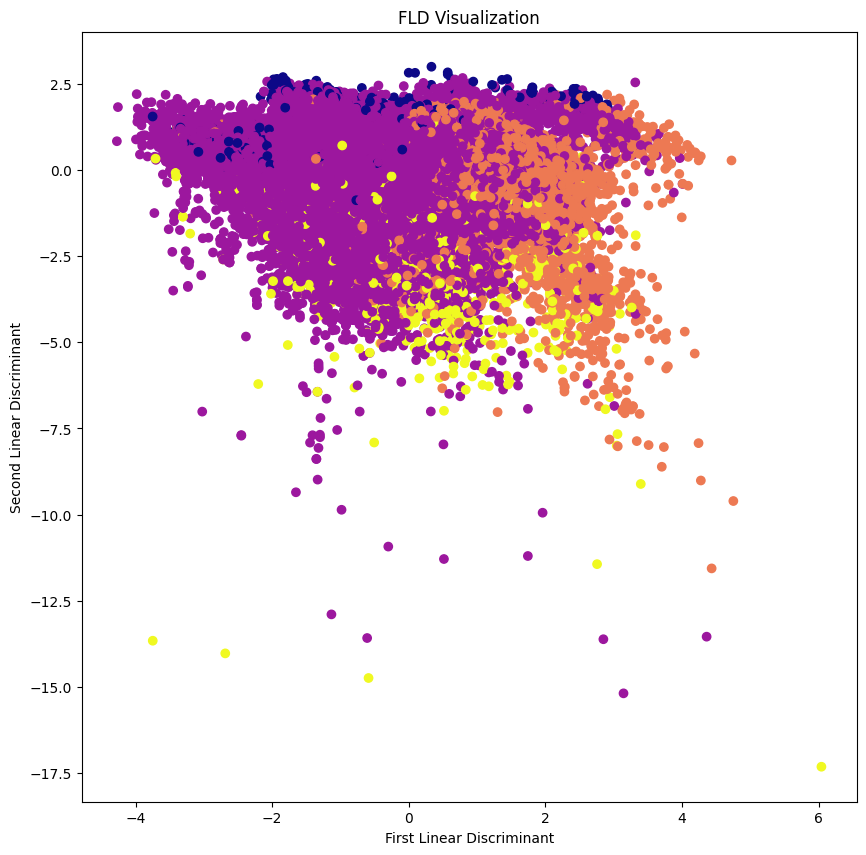

In [79]:
lda = LDA(n_components=3)
lda.fit(X_train, y_train)
lda_X_train = lda.transform(X_train)
#Plot the visualization
plt.figure(figsize=(10,10))
plt.scatter(lda_X_train[:,0], lda_X_train[:,1], c=y_train, cmap='plasma')
plt.xlabel('First Linear Discriminant')
plt.ylabel('Second Linear Discriminant')
plt.title('FLD Visualization')
plt.show()


In [80]:
#Perform FLD on testing data
lda = LDA(n_components=3)
lda.fit(X_test, y_test)
lda_X_test = lda.transform(X_test)

## Classification/Regression

### Minimum Mahalanobis Distance Classifier (PCA)

In [81]:
def mahalanobis_metric(x, y):
    covariance_matrix = np.cov(pca_X_train, rowvar=False)
    inv_covariance_matrix = np.linalg.pinv(covariance_matrix)
    return mahalanobis(x, y, inv_covariance_matrix)

# Initialize and train NearestCentroid with Mahalanobis distance
nc = NearestCentroid(metric=mahalanobis_metric)
nc.fit(pca_X_train, y_train)

# Predict on test data
y_pred_mp = nc.predict(pca_X_test)

# Calculate accuracy
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_mp, target_names=target_names))
accuracy = accuracy_score(y_pred_mp, y_test)
print(f'Overall Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

  Severity 1       0.01      0.09      0.01       230
  Severity 2       0.75      0.37      0.49     13257
  Severity 3       0.06      0.09      0.07      2910
  Severity 4       0.02      0.12      0.03       342

    accuracy                           0.31     16739
   macro avg       0.21      0.17      0.15     16739
weighted avg       0.61      0.31      0.40     16739

Overall Accuracy: 30.909851245594123%


### Minimum Mahalanobis Distance Classifier (FLD)

In [82]:
def mahalanobis_metric(x, y):
    covariance_matrix = np.cov(lda_X_train, rowvar=False)
    inv_covariance_matrix = np.linalg.pinv(covariance_matrix)
    return mahalanobis(x, y, inv_covariance_matrix)

# Initialize and train NearestCentroid with Mahalanobis distance
nc = NearestCentroid(metric=mahalanobis_metric)
nc.fit(lda_X_train, y_train)

# Predict on test data
y_pred_mf = nc.predict(lda_X_test)

# Calculate accuracy
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_mf, target_names=target_names))
accuracy = accuracy_score(y_pred_mf, y_test)
print(f'Overall Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

  Severity 1       0.06      0.74      0.10       230
  Severity 2       0.95      0.40      0.56     13257
  Severity 3       0.44      0.85      0.58      2910
  Severity 4       0.08      0.57      0.14       342

    accuracy                           0.48     16739
   macro avg       0.38      0.64      0.34     16739
weighted avg       0.83      0.48      0.55     16739

Overall Accuracy: 48.40193559949818%


### Minimum Mahalanobis Distance Classifier (Non-reduced)

In [83]:
def mahalanobis_metric(x, y):
    covariance_matrix = np.cov(X_train, rowvar=False)
    inv_covariance_matrix = np.linalg.pinv(covariance_matrix)
    return mahalanobis(x, y, inv_covariance_matrix)

# Initialize and train NearestCentroid with Mahalanobis distance
nc = NearestCentroid(metric=mahalanobis_metric)
nc.fit(X_train, y_train)

# Predict on test data
y_pred_mn = nc.predict(X_test)

# Calculate accuracy
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_mn, target_names=target_names))
accuracy = accuracy_score(y_pred_mn, y_test)
print(f'Overall Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

  Severity 1       0.06      0.75      0.11       230
  Severity 2       0.96      0.40      0.56     13257
  Severity 3       0.43      0.86      0.58      2910
  Severity 4       0.08      0.56      0.14       342

    accuracy                           0.49     16739
   macro avg       0.38      0.64      0.35     16739
weighted avg       0.83      0.49      0.55     16739

Overall Accuracy: 48.79025031363881%


### Kmeans Classifier (PCA)

In [84]:
kmeans = KMeans(n_clusters=6, random_state=21)
kmeans.fit(pca_X_train)
y_pred_kp = kmeans.predict(pca_X_test)
accuracy = accuracy_score(y_pred_kp, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_kp))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.01      0.14      0.01       230
         2.0       0.82      0.35      0.49     13257
         3.0       0.00      0.00      0.00      2910
         4.0       0.03      0.30      0.05       342
         5.0       0.00      0.00      0.00         0

    accuracy                           0.29     16739
   macro avg       0.14      0.13      0.09     16739
weighted avg       0.65      0.29      0.39     16739

Accuracy: 28.573988888225106%


### Kmeans Classifier (FLD)

In [85]:
kmeans = KMeans(n_clusters=5, random_state=21)
kmeans.fit(lda_X_train)
y_pred_kf = kmeans.predict(lda_X_test)
accuracy = accuracy_score(y_pred_kf, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_kf))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00       230
         2.0       0.93      0.32      0.48     13257
         3.0       0.43      0.51      0.47      2910
         4.0       0.02      0.20      0.04       342

    accuracy                           0.35     16739
   macro avg       0.28      0.21      0.20     16739
weighted avg       0.81      0.35      0.46     16739

Accuracy: 34.68546508154609%


### Kmeans Classifier (Non-reduced)

In [86]:
kmeans = KMeans(n_clusters=8, random_state=21)
kmeans.fit(X_train)
y_pred_kn = kmeans.predict(X_test)
accuracy = accuracy_score(y_pred_kn, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_kn))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.03      0.45      0.05       230
         2.0       0.84      0.22      0.35     13257
         3.0       0.28      0.18      0.22      2910
         4.0       0.03      0.01      0.01       342
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0

    accuracy                           0.21     16739
   macro avg       0.15      0.11      0.08     16739
weighted avg       0.71      0.21      0.32     16739

Accuracy: 21.381205567835593%


### Decision Tree Regression (PCA)

In [87]:
dtree = DecisionTreeClassifier()
dtree.fit(pca_X_train, y_train)
y_pred_dtp = dtree.predict(pca_X_test)
accuracy = accuracy_score(y_pred_dtp, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_dtp))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         1.0       0.01      0.06      0.02       230
         2.0       0.77      0.67      0.72     13257
         3.0       0.16      0.12      0.13      2910
         4.0       0.02      0.13      0.04       342

    accuracy                           0.56     16739
   macro avg       0.24      0.24      0.23     16739
weighted avg       0.64      0.56      0.59     16739

Accuracy: 55.77991516817015%


### Decision Tree Regression (FLD)

In [88]:
dtree = DecisionTreeClassifier()
dtree.fit(lda_X_train, y_train)
y_pred_dtf = dtree.predict(lda_X_test)
accuracy = accuracy_score(y_pred_dtf, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_dtf))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         1.0       0.21      0.21      0.21       230
         2.0       0.86      0.85      0.85     13257
         3.0       0.47      0.47      0.47      2910
         4.0       0.09      0.10      0.09       342

    accuracy                           0.76     16739
   macro avg       0.41      0.41      0.41     16739
weighted avg       0.76      0.76      0.76     16739

Accuracy: 76.20526913196726%


### Decision Tree Regression (Non-reduced)

In [89]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred_dtn = dtree.predict(X_test)
accuracy = accuracy_score(y_pred_dtn, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_dtn))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         1.0       0.66      0.67      0.66       230
         2.0       0.93      0.93      0.93     13257
         3.0       0.78      0.77      0.77      2910
         4.0       0.30      0.30      0.30       342

    accuracy                           0.89     16739
   macro avg       0.67      0.67      0.67     16739
weighted avg       0.89      0.89      0.89     16739

Accuracy: 88.93601768325468%


## Running Random Forest like Dr.Zhou with our larger dataset

### Random Forest Regression (PCA)

In [107]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(pca_X_train, y_train)
y_pred_rfp = rfc.predict(pca_X_test)
accuracy = accuracy_score(y_pred_rfp, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_rfp))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       230
         2.0       0.79      0.99      0.88     13257
         3.0       0.07      0.00      0.00      2910
         4.0       0.00      0.00      0.00       342

    accuracy                           0.79     16739
   macro avg       0.21      0.25      0.22     16739
weighted avg       0.64      0.79      0.70     16739

Accuracy: 78.75619810024493%


### Random Forest Regression (FLD)

In [108]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(lda_X_train, y_train)
y_pred_rff = rfc.predict(lda_X_test)
accuracy = accuracy_score(y_pred_rff, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_rff))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         1.0       0.41      0.13      0.20       230
         2.0       0.86      0.93      0.89     13257
         3.0       0.59      0.46      0.52      2910
         4.0       0.42      0.05      0.09       342

    accuracy                           0.82     16739
   macro avg       0.57      0.39      0.43     16739
weighted avg       0.80      0.82      0.80     16739

Accuracy: 81.74920843539041%


### Random Forest Regression (Non-reduced)

In [109]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred_rfn = rfc.predict(X_test)
accuracy = accuracy_score(y_pred_rfn, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_rfn))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         1.0       0.71      0.78      0.74       230
         2.0       0.94      0.97      0.95     13257
         3.0       0.87      0.81      0.84      2910
         4.0       0.52      0.25      0.33       342

    accuracy                           0.92     16739
   macro avg       0.76      0.70      0.72     16739
weighted avg       0.92      0.92      0.92     16739

Accuracy: 92.18591313698549%


## Fusion

### Majority-Voting

In [90]:
#Implement majority voting fusion on three models
y_pred = []
for i in range(len(y_pred_dtp)):
    dtp = y_pred_dtp[i]
    mf = y_pred_mf[i]
    mn = y_pred_mn[i]
    #Choose the one that occurs the most of the three
    if dtp == mf or dtp == mn:
        y_pred.append(dtp)
    elif mf == mn:
        y_pred.append(mf)
    else:
        y_pred.append(np.random.choice([dtp, mf, mn]))
accuracy = accuracy_score(y_pred, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         1.0       0.06      0.72      0.11       230
         2.0       0.95      0.42      0.58     13257
         3.0       0.43      0.85      0.58      2910
         4.0       0.08      0.56      0.14       342

    accuracy                           0.50     16739
   macro avg       0.38      0.64      0.35     16739
weighted avg       0.83      0.50      0.57     16739

Accuracy: 50.2658462273732%


### AdaBoost

In [91]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=21)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
accuracy = accuracy_score(y_pred_ada, y_test)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred_ada))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

         1.0       0.74      0.76      0.75       230
         2.0       0.94      0.96      0.95     13257
         3.0       0.85      0.81      0.83      2910
         4.0       0.46      0.29      0.36       342

    accuracy                           0.92     16739
   macro avg       0.75      0.70      0.72     16739
weighted avg       0.91      0.92      0.91     16739

Accuracy: 91.68409104486528%


### XGBoost

In [110]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
xgb = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 5)
xgb.fit(X_train, y_train_le)
y_pred_xgb = xgb.predict(X_test)
accuracy = accuracy_score(y_pred_xgb, y_test_le)
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test_le, y_pred_xgb))
print(f'Accuracy: {accuracy*100}%')

              precision    recall  f1-score   support

           0       0.72      0.77      0.75       230
           1       0.94      0.97      0.95     13257
           2       0.86      0.80      0.83      2910
           3       0.70      0.27      0.39       342

    accuracy                           0.92     16739
   macro avg       0.81      0.70      0.73     16739
weighted avg       0.92      0.92      0.92     16739

Accuracy: 92.21578349961167%


## Performance Evaluation

![performanceEval](https://github.com/clayshubert/USAccidentAnalysisML/blob/clay-dev/data/performanceEval.png?raw=true)